In [21]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import random as rng

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\chris\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib.libs'

In [5]:
def rgb_2_gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

In [6]:
images = []
for filename in glob.glob("data\\bacteria\\*.jpg"):
  img = cv.imread(filename)
  img = rgb_2_gray(img)
  img = np.uint8(img)
  images.append(img)


In [14]:
THRESH_1 = 10
THRESH_2 = 15

rng.seed(12345)

canny_output = cv.Canny(images[0], 10, 15)
contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
    contours_poly[i] = cv.approxPolyDP(c, 3, True)
    boundRect[i] = cv.boundingRect(contours_poly[i])
    centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

In [17]:
print(len(contours))

85782


In [18]:
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
for i in range(len(contours[1:20])):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, contours_poly, i, color)
    cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
    (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

In [19]:
cv.imshow('Contours', drawing)

### Test out YOLO

In [23]:
import yolov5
from torchsummary import summary

In [39]:
model = yolov5.load('keremberke/yolov5n-blood-cell')

YOLOv5  2023-10-25 Python-3.11.5 torch-2.1.0+cpu CPU



Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


In [38]:
result = model(images[1])
predictions = result.pred[0]
print(predictions)
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

tensor([], size=(0, 6))


In [35]:
print(boxes)

tensor([], size=(0, 4))


In [29]:
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
img = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'

# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

In [31]:
print(boxes)

tensor([[1187.03088,  543.88135, 1278.18689,  720.00000]])


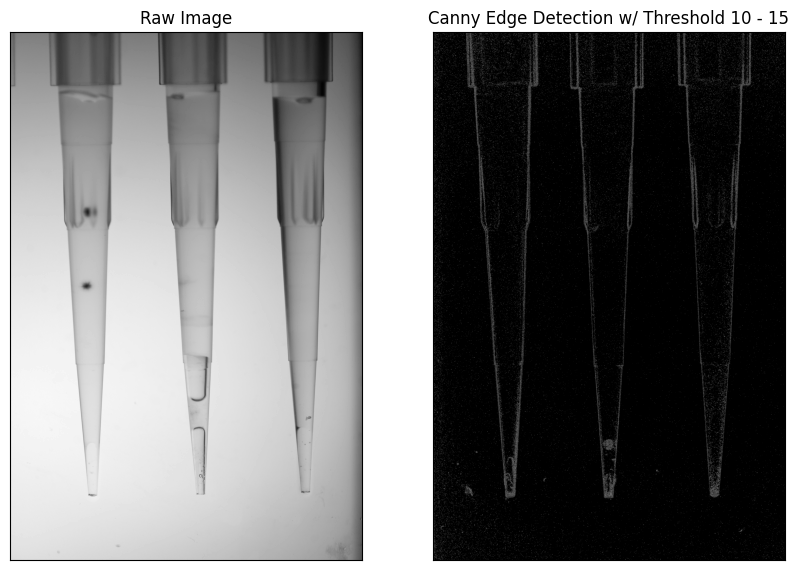

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(img, cmap='gray')
axes[0].title.set_text("Raw Image")
axes[0].get_yaxis().set_visible(False)
axes[0].get_xaxis().set_visible(False)

axes[1].imshow(canny_out_10_15, cmap='gray')
axes[1].title.set_text("Canny Edge Detection w/ Threshold 10 - 15")
axes[1].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)